In [216]:
import os
import re
import sys
import csv
import math
import glob
import json
import pickle as pkl
from collections import defaultdict, OrderedDict
import numpy as np
import csv

Load some data

In [217]:
pwd = '/Users/jonathanlorraine/Desktop/CSC2541_DeepRL/menas/src/graphing/'  # get with `pwd` for data location

def parse_info(loc):
    with open(pwd + loc, newline='') as f:
        raw_info = list(csv.reader(f))
        keys = [r for r in raw_info[0]]
        print(keys)
        infos = {key: [] for key in keys}
        for r in raw_info[1:]:
            for enum_ind, key in enumerate(keys):
                infos[key] += [float(r[enum_ind])]
    return infos

darts_info = parse_info('run_eval-EXP-DARTS.csv')
darts_1st_info = parse_info('run_eval-EXP-DARTS_1ST_ORDER.csv')
enas_info = parse_info('run_eval-EXP-ENAS.csv')
ours_info = parse_info('run_eval-EXP-OURS.csv')
    
final_infos = [darts_info, darts_1st_info, enas_info, ours_info]

second_order_darts = parse_info('run_search-EXP-Unroll-DiffUnroll.csv')
first_order_darts = parse_info('run_search-EXP-NoUnroll.csv')
extrapolate_darts = parse_info('run_search-EXP-Unroll-NoDiffUnroll.csv')
search_infos = [second_order_darts, first_order_darts, extrapolate_darts]

['Wall time', 'Step', 'Value']
['Wall time', 'Step', 'Value']
['Wall time', 'Step', 'Value']
['Wall time', 'Step', 'Value']
['Wall time', 'Step', 'Value']
['Wall time', 'Step', 'Value']
['Wall time', 'Step', 'Value']


In [218]:
def update_mutable(ar):
    ar['Value'] = np.array(ar['Value'])
    where_nan = where_are_NaNs = np.isnan(ar['Value'])
    ar['Value'][where_nan] = np.inf
    ar['Wall time'] = np.array(ar['Wall time'])
    ar['Wall time'] -= ar['Wall time'][0]
    mean_length = 30
    ar['mean_value'] = np.array([np.mean(ar['Value'][np.maximum(0, i-mean_length):i+1]) for i in range(len(ar['Value']))])
    ar['std_value'] = np.array([np.std(ar['Value'][np.maximum(0, i-mean_length):i+1]) for i in range(len(ar['Value']))])
    ar['min_value'] = [np.min(ar['mean_value'][:i+1]) for i in range(len(ar['mean_value']))]

[update_mutable(ar) for ar in final_infos]
[update_mutable(ar) for ar in search_infos]

[None, None, None]

In [219]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Set some parameters.
font = {'family': 'Times New Roman'}
mpl.rc('font', **font)
font_size = 50
mpl.rcParams['legend.fontsize'] = font_size
mpl.rcParams['axes.labelsize'] = font_size
mpl.rcParams['xtick.labelsize'] = font_size
mpl.rcParams['ytick.labelsize'] = font_size
mpl.rcParams['axes.grid'] = True

y_val = 'mean_value'
def graph_info(ax, info, label, color, x_val='Step'):
    ax.semilogx(info[x_val], info[y_val], c=color,label=label)
    ax.axhline(info['min_value'][-1], c=color, linestyle='--')
    ax.fill_between(info[x_val], 
                    info[y_val] + error_scale*info['std_value'],
                    info[y_val] - error_scale*info['std_value'],
                    color=color, alpha=0.25)

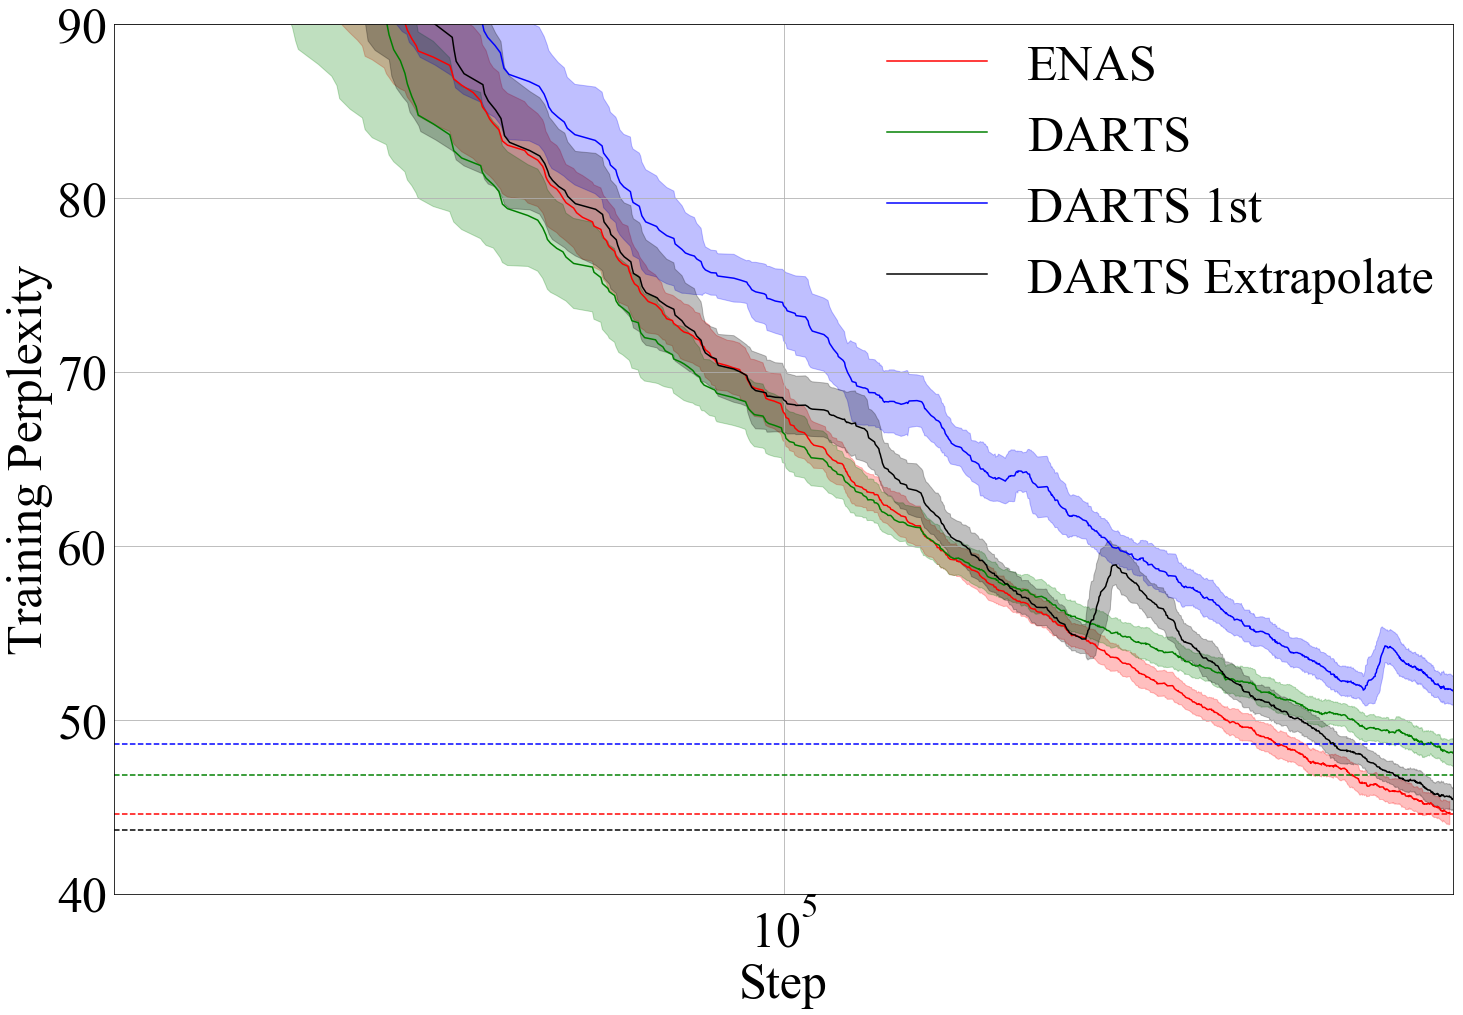

In [233]:
# Create figure and axes.
fig = plt.figure(figsize=(24,16))
num_rows, num_cols = 1, 1
axs = [fig.add_subplot(num_rows, num_cols, i+1) for i in range(num_rows * num_cols)]


error_scale = 1.0

graph_info(axs[0], enas_info, 'ENAS', 'r')
graph_info(axs[0], darts_info, 'DARTS', 'g')
graph_info(axs[0], darts_1st_info, 'DARTS 1st', 'b')
graph_info(axs[0], ours_info, 'DARTS Extrapolate', 'k')

axs[0].set_ylim(40, 90)
axs[0].set_xlim(2*10e3, 5*10e4)
for a in axs:
    a.legend(fancybox=True, borderaxespad=0.0, framealpha=0.0)
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Training Perplexity')

axs[0].tick_params(axis='x', which='both', bottom=False, top=False)
axs[0].tick_params(axis='y', which='both', left=False, right=False)
6888

fig.savefig(pwd + 'final_training_comparison.pdf', bbox_inches='tight', dpi=200)
#fig.clf()

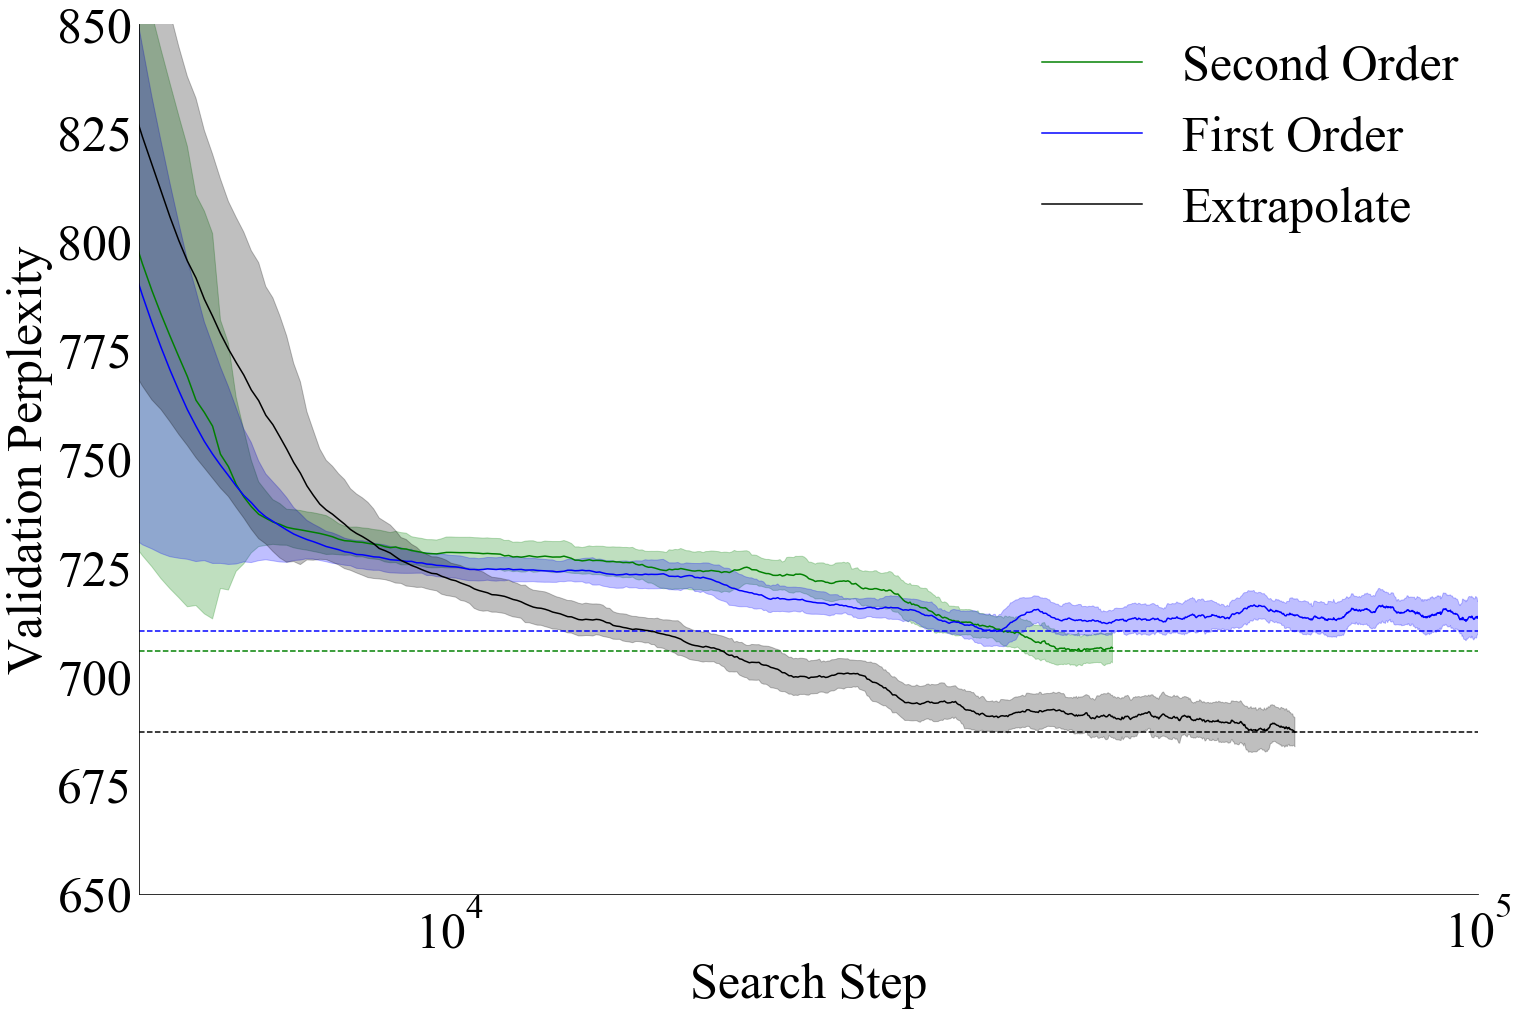

In [224]:
# Create figure and axes.
fig = plt.figure(figsize=(24,16))
num_rows, num_cols = 1, 1
axs = [fig.add_subplot(num_rows, num_cols, i+1) for i in range(num_rows * num_cols)]

graph_info(axs[0], second_order_darts, 'Second Order', 'g')
#axs[0].semilogx(second_order_darts['Step'], second_order_darts['min_value'], c='g', label='Second Order')
#print(second_order_darts['min_value'])
graph_info(axs[0], first_order_darts, 'First Order', 'b')
graph_info(axs[0], extrapolate_darts, 'Extrapolate', 'k')


axs[0].set_ylim(650, 850)
axs[0].set_xlim(5 * 10e2, 10e4)
for a in axs:
    a.legend(fancybox=True, borderaxespad=0.0, framealpha=0.0)
axs[0].set_xlabel('Search Step')
axs[0].set_ylabel('Validation Perplexity')

axs[0].tick_params(axis='x', which='both', bottom=False, top=False)
axs[0].tick_params(axis='y', which='both', left=False, right=False)
axs[0].grid(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

fig.savefig(pwd + 'search_comparison_step.pdf', bbox_inches='tight', dpi=200)
#fig.clf()

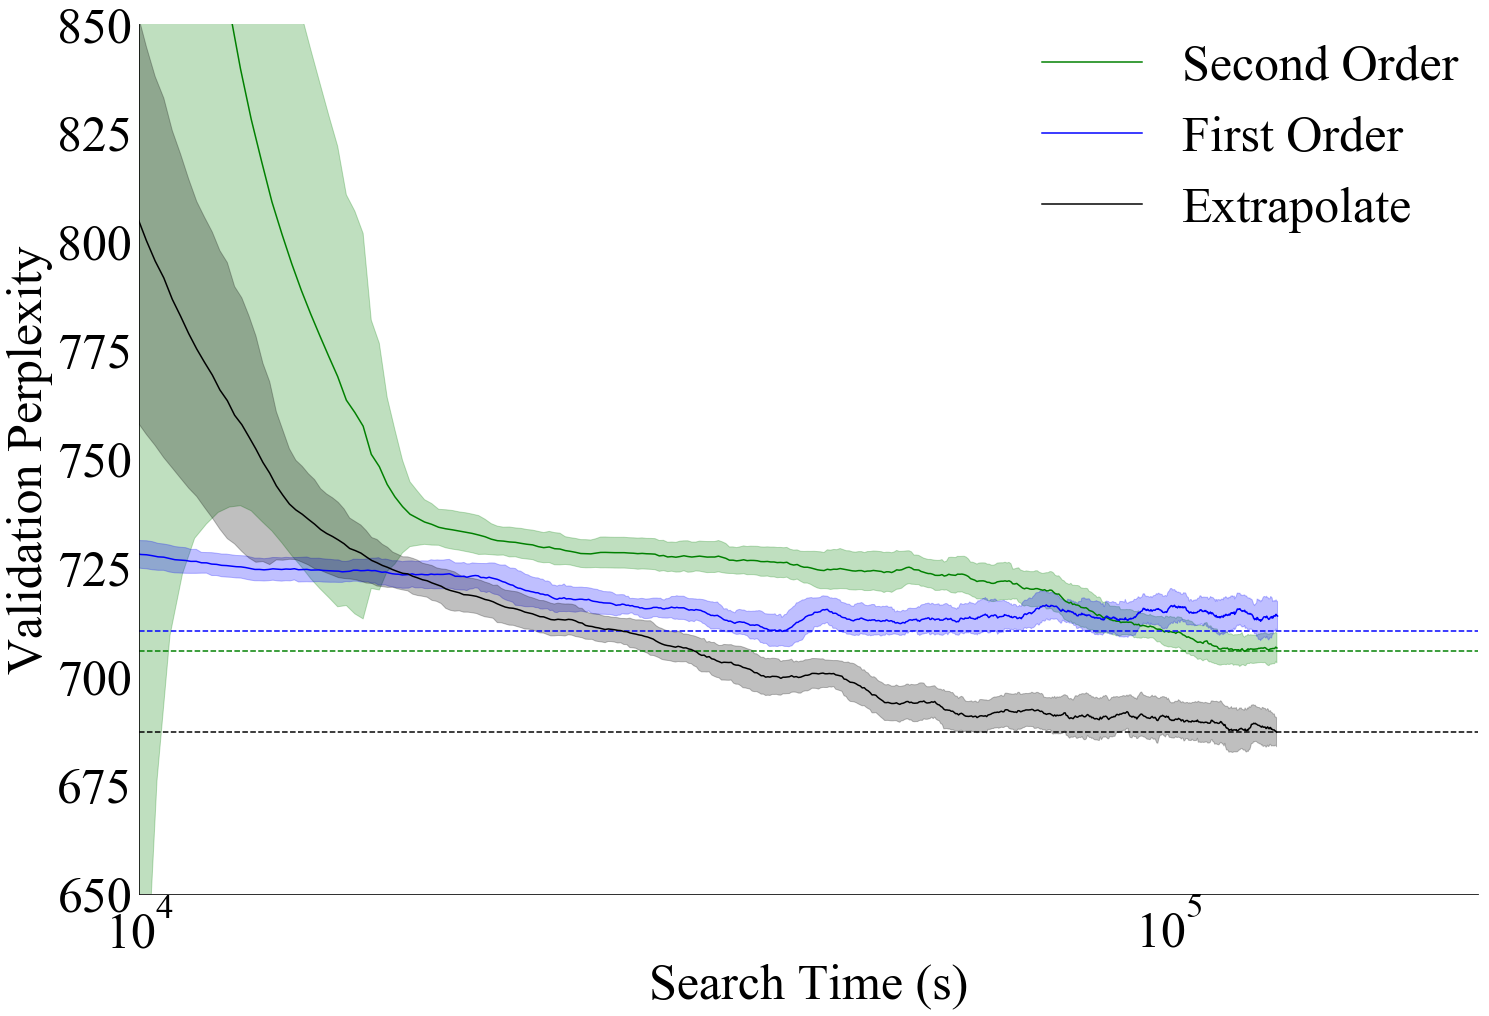

In [236]:
# Create figure and axes.
fig.clf()
fig = plt.figure(figsize=(24,16))
num_rows, num_cols = 1, 1
axs = [fig.add_subplot(num_rows, num_cols, i+1) for i in range(num_rows * num_cols)]

graph_info(axs[0], second_order_darts, 'Second Order', 'g', x_val='Wall time')
#axs[0].semilogx(second_order_darts['Step'], second_order_darts['min_value'], c='g', label='Second Order')
#print(second_order_darts['min_value'])
graph_info(axs[0], first_order_darts, 'First Order', 'b', x_val='Wall time')
graph_info(axs[0], extrapolate_darts, 'Extrapolate', 'k', x_val='Wall time')


axs[0].set_ylim(650, 850)
axs[0].set_xlim(10e3, 2*10e4)
for a in axs:
    a.legend(fancybox=True, borderaxespad=0.0, framealpha=0.0)
axs[0].set_xlabel('Search Time (s)')
axs[0].set_ylabel('Validation Perplexity')

axs[0].tick_params(axis='x', which='both', bottom=False, top=False)
axs[0].tick_params(axis='y', which='both', left=False, right=False)
axs[0].grid(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

fig.savefig(pwd + 'search_comparison_time.pdf', bbox_inches='tight', dpi=200)
#fig.clf()